In [1]:
!pip freeze | grep "qiskit"

qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2
qiskit-nature==0.7.2


In [8]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import pauli_error, depolarizing_error
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

aer_sim = AerSimulator()

Two types of probabilities : Probability of the noise and Probability of failiure

In [9]:
p1 = 0.01
p3 = 3 * p1**2 * (1 - p1) + p1**3  # probability of 2 or 3 errors
print("Probability of a single reply being garbled: {}".format(p1))
print("Probability of a majority of the three replies being garbled: {:.4f}".format(p3))

Probability of a single reply being garbled: 0.01
Probability of a majority of the three replies being garbled: 0.0003


In [10]:
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        error_meas, "measure"
    )  # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(
        error_gate1, ["x"]
    )  # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(
        error_gate2, ["cx"]
    )  # two qubit gate error is applied to cx gates

    return noise_model

In [11]:
noise_model = get_noise(0.01, 0.01)

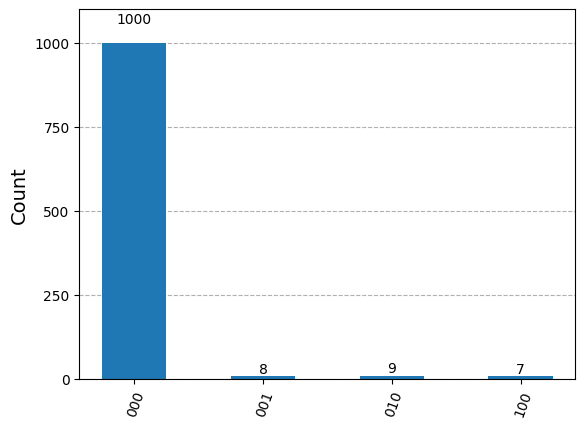

In [13]:
qc0 = QuantumCircuit(3)  # initialize circuit with three qubits in the 0 state
qc0.measure_all()  # measure the qubits

# run the circuit with the noise model and extract the counts

counts = aer_sim.run(qc0, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

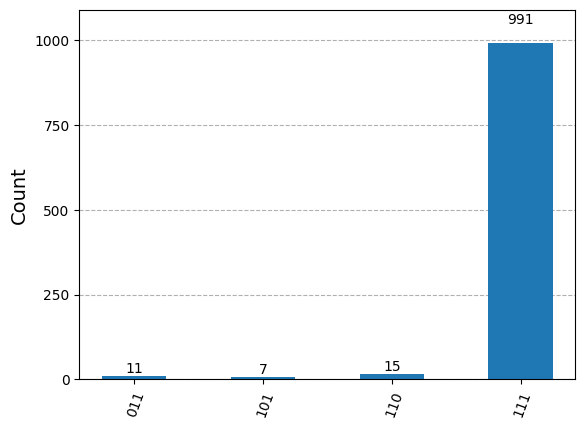

In [14]:
qc1 = QuantumCircuit(3)  # initialize circuit with three qubits in the 0 state
qc1.x([0, 1, 2])  # flip each 0 to 1

qc1.measure_all()  # measure the qubits

# run the circuit with th noise model and extract the counts
counts = aer_sim.run(qc1, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

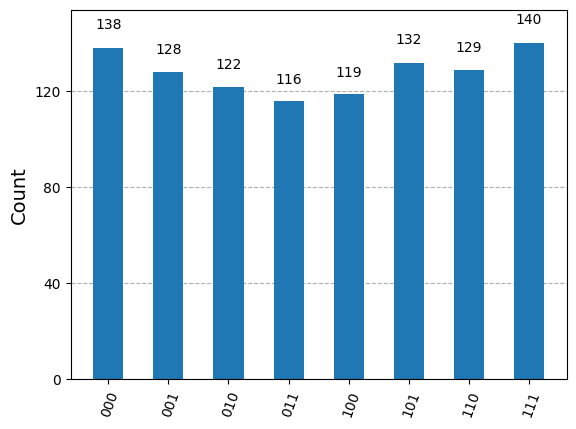

In [15]:
noise_model = get_noise(0.5, 0.0)
counts = aer_sim.run(qc1, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

In [16]:
cq = QuantumRegister(2, "code_qubit")
lq = QuantumRegister(1, "auxiliary_qubit")
sb = ClassicalRegister(1, "syndrome_bit")
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

code_qubit_0: ──■──────────
                   │          
   code_qubit_1: ──┼────■─────
                 ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ┤ X ├┤ X ├┤M├
                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════╩═
                            0

In [18]:
counts = aer_sim.run(qc).result().get_counts()
print("Results:", counts)

Results: {'0': 1024}


In [19]:
import numpy as np
from numpy import pi, linalg, array, kron
import math

In [20]:
qc_sup = QuantumCircuit(cq)
qc_sup.ry(pi / 3, cq[0])
qc_sup.cx(cq[0], cq[1])
qc.compose(qc_sup, front=True).draw()

┌─────────┐                  
   code_qubit_0: ┤ Ry(π/3) ├──■────■──────────
                 └─────────┘┌─┴─┐  │          
   code_qubit_1: ───────────┤ X ├──┼────■─────
                            └───┘┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ────────────────┤ X ├┤ X ├┤M├
                                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════════════════════╩═
                                            0

In [21]:
counts = aer_sim.run(qc).result().get_counts()
print("Results:", counts)

Results: {'0': 1024}


In [22]:
qc_diff = QuantumCircuit(cq)
qc_diff.h(cq[0])
qc_diff.cx(cq[0], cq[1])
qc_diff.x(cq[0])
qc.compose(qc_diff, front=True).draw()

┌───┐     ┌───┐             
   code_qubit_0: ┤ H ├──■──┤ X ├──■──────────
                 └───┘┌─┴─┐└───┘  │          
   code_qubit_1: ─────┤ X ├───────┼────■─────
                      └───┘     ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ───────────────┤ X ├┤ X ├┤M├
                                └───┘└───┘└╥┘
 syndrome_bit: 1/══════════════════════════╩═
                                           0

In [23]:
qc2 = qc.compose(qc_diff, front=True)
counts = aer_sim.run(qc2).result().get_counts()
print("Results:", counts)

Results: {'1': 1024}


# PART 2

In [32]:
# FOLLOWING HAS BEEN COPY-PASTED ASIS WITHOUT ANY MODIFICATION
# FROM QISKIT IGNIS: https://github.com/qiskit-community/qiskit-ignis/blob/stable/0.6/qiskit/ignis/verification/topological_codes/circuits.py
class RepetitionCode:
    """
    Implementation of a distance d repetition code, implemented over
    T syndrome measurement rounds.
    """

    def __init__(self, d, T=0):
        """
        Creates the circuits corresponding to a logical 0 and 1 encoded
        using a repetition code.

        Args:
            d (int): Number of code qubits (and hence repetitions) used.
            T (int): Number of rounds of ancilla-assisted syndrome measurement.


        Additional information:
            No measurements are added to the circuit if `T=0`. Otherwise
            `T` rounds are added, followed by measurement of the code
            qubits (corresponding to a logical measurement and final
            syndrome measurement round).
        """

        self.d = d
        self.T = 0

        self.code_qubit = QuantumRegister(d, "code_qubit")
        self.link_qubit = QuantumRegister((d - 1), "link_qubit")
        self.qubit_registers = {"code_qubit", "link_qubit"}

        self.link_bits = []
        self.code_bit = ClassicalRegister(d, "code_bit")

        self.circuit = {}
        for log in ["0", "1"]:
            self.circuit[log] = QuantumCircuit(
                self.link_qubit, self.code_qubit, name=log
            )

        self._preparation()

        for _ in range(T - 1):
            self.syndrome_measurement()

        if T != 0:
            self.syndrome_measurement(reset=False)
            self.readout()

    def get_circuit_list(self):
        """
        Returns:
            circuit_list: self.circuit as a list, with
            circuit_list[0] = circuit['0']
            circuit_list[1] = circuit['1']
        """
        circuit_list = [self.circuit[log] for log in ["0", "1"]]
        return circuit_list

    def x(self, logs=("0", "1"), barrier=False):
        """
        Applies a logical x to the circuits for the given logical values.

        Args:
            logs (list or tuple): List or tuple of logical values expressed as
                strings.
            barrier (bool): Boolean denoting whether to include a barrier at
                the end.
        """
        for log in logs:
            for j in range(self.d):
                self.circuit[log].x(self.code_qubit[j])
            if barrier:
                self.circuit[log].barrier()

    def _preparation(self):
        """
        Prepares logical bit states by applying an x to the circuit that will
        encode a 1.
        """
        self.x(["1"])

    def syndrome_measurement(self, reset=True, barrier=False):
        """
        Application of a syndrome measurement round.

        Args:
            reset (bool): If set to true add a boolean at the end of each round
            barrier (bool): Boolean denoting whether to include a barrier at the end.
        """
        self.link_bits.append(
            ClassicalRegister((self.d - 1), "round_" + str(self.T) + "_link_bit")
        )

        for log in ["0", "1"]:

            self.circuit[log].add_register(self.link_bits[-1])

            for j in range(self.d - 1):
                self.circuit[log].cx(self.code_qubit[j], self.link_qubit[j])

            for j in range(self.d - 1):
                self.circuit[log].cx(self.code_qubit[j + 1], self.link_qubit[j])

            for j in range(self.d - 1):
                self.circuit[log].measure(self.link_qubit[j], self.link_bits[self.T][j])
                if reset:
                    self.circuit[log].reset(self.link_qubit[j])

            if barrier:
                self.circuit[log].barrier()

        self.T += 1

    def readout(self):
        """
        Readout of all code qubits, which corresponds to a logical measurement
        as well as allowing for a measurement of the syndrome to be inferred.
        """
        for log in ["0", "1"]:
            self.circuit[log].add_register(self.code_bit)
            self.circuit[log].measure(self.code_qubit, self.code_bit)

    def process_results(self, raw_results):
        """
        Args:
            raw_results (dict): A dictionary whose keys are logical values,
                and whose values are standard counts dictionaries, (as
                obtained from the `get_counts` method of a ``qiskit.Result``
                object).

        Returns:
            results: Dictionary with the same structure as the input, but with
                the bit strings used as keys in the counts dictionaries
                converted to the form required by the decoder.

        Additional information:
            The circuits must be executed outside of this class, so that
            their is full freedom to compile, choose a backend, use a
            noise model, etc. The results from these executions should then
            be used to create the input for this method.
        """
        results = {}
        for log in raw_results:
            results[log] = {}
            for string in raw_results[log]:

                # logical readout taken from
                measured_log = string[0] + " " + string[self.d - 1]

                # final syndrome deduced from final code qubit readout
                full_syndrome = ""
                for j in range(self.d - 1):
                    full_syndrome += "0" * (string[j] == string[j + 1]) + "1" * (
                        string[j] != string[j + 1]
                    )
                # results from all other syndrome measurements then added
                full_syndrome = full_syndrome + string[self.d :]

                # changes between one syndrome and the next then calculated
                syndrome_list = full_syndrome.split(" ")
                syndrome_changes = ""
                for t in range(self.T + 1):
                    for j in range(self.d - 1):
                        if t == 0:
                            change = syndrome_list[-1][j] != "0"
                        else:
                            change = syndrome_list[-t][j] != syndrome_list[-t - 1][j]
                        syndrome_changes += "0" * (not change) + "1" * change
                    syndrome_changes += " "

                # the space separated string of syndrome changes then gets a
                # double space separated logical value on the end
                new_string = measured_log + "  " + syndrome_changes[:-1]

                results[log][new_string] = raw_results[log][string]

        return results

In [33]:
n = 3
T = 1
code = RepetitionCode(n, T)

In [34]:
code.circuit["1"].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ─────┤ X ├─────┤ X ├────────┤M├─────────
                         └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ───────┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                    ┌───┐  │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ┤ X ├──■────┼────┼────┼──┤M├─╫──╫───────
                    ├───┤       │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ┤ X ├───────■────■────┼───╫──╫──╫─┤M├───
                    ├───┤                 │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ┤ X ├─────────────────■───╫──╫──╫──╫─┤M├
                    └───┘                     ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/══════════════════════════╬══╩══╩══╬══╬═
                                              ║  0  1  ║  ║ 
        code_bit: 3/══════════════════════════╩════════╩══╩═
                                              0        1  2

In [36]:
def get_raw_results(code, noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for i in range(2):
        job = aer_sim.run(circuits[i], noise_model=noise_model, shots=10)
        raw_results[str(i)] = job.result().get_counts(str(i))
    return raw_results


raw_results = get_raw_results(code)
for i in raw_results:
    print("Logical", i, ":", raw_results[i], "\n")

Logical 0 : {'000 00': 10} 

Logical 1 : {'111 00': 10} 



In [37]:
code = RepetitionCode(3, 1)

noise_model = get_noise(0.01, 0.5)

raw_results = get_raw_results(code, noise_model)
for log in raw_results:
    print("Logical", log, ":", raw_results[log], "\n")

Logical 0 : {'000 01': 1, '011 01': 1, '111 01': 1, '000 10': 2, '000 00': 3, '101 10': 1, '110 11': 1} 

Logical 1 : {'010 10': 1, '101 01': 1, '001 00': 1, '111 11': 2, '111 10': 1, '100 10': 1, '111 00': 1, '101 00': 1, '101 10': 1} 



In [39]:
# FOLLOWING HAS BEEN COPY-PASTED ASIS WITHOUT ANY MODIFICATION
# FROM QISKIT IGNIS: https://github.com/qiskit-community/qiskit-ignis/blob/24e1dbf4740607a96a43e7893d9effa56d832568/qiskit/ignis/verification/topological_codes/fitters.py#L521
def lookuptable_decoding(training_results, real_results):
    """
    Calculates the logical error probability using postselection decoding.
    This postselects all results with trivial syndrome.

    Args:
        training_results (dict): A results dictionary, as produced by the
            ``process_results`` method of a code.
        real_results (dict): A results dictionary, as produced by the
            ``process_results`` method of a code.

    Returns:
        dict: Dictionary of logical error probabilities for
            each of the encoded logical states whose results were given in
            the input.


    Additional information:
        Given a two dictionaries of results, as produced by a code object,
        thelogical error probability is calculated for lookup table
        decoding. This is done using `training_results` as a guide to which
        syndrome is most probable for each logical value, and the
        probability is calculated for the results in `real_results`.
    """

    logical_prob = {}
    for log in real_results:
        shots = 0
        incorrect_shots = 0
        for string in real_results[log]:

            p = {}
            for testlog in ["0", "1"]:
                if string in training_results[testlog]:
                    p[testlog] = training_results[testlog][string]
                else:
                    p[testlog] = 0

            shots += real_results[log][string]
            if p["1" * (log == "0") + "0" * (log == "1")] > p[log]:
                incorrect_shots += real_results[log][string]

        logical_prob[log] = incorrect_shots / shots

    return logical_prob

In [40]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = aer_sim.run(circuits[log], noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

In [41]:
P = lookuptable_decoding(table_results, raw_results)
print("P =", P)

P = {'0': 0.4, '1': 0.2}
